# Tutorial Cover-Song-Identification based on Triplet-Loss

- date: 2024-10-01
- author: geoffroy.peeters@telecom-paris.fr

Datasets are available at
- Cover-1000 https://www.covers1000.net/dataset.html
- DA-TACOS https://github.com/MTG/da-tacos 

The code of the model is based on MOVE 
- Paper: https://arxiv.org/pdf/1910.12551 
- Code: https://github.com/furkanyesiler/move

The code for evaluation is based on
- https://gist.github.com/bwhite/3726239

In [ ]:
!git clone https://github.com/geoffroypeeters/DL101forMIR_notebook.git
%cd DL101forMIR_notebook
!ls

## Import packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime


import librosa
import matplotlib.pyplot as plt
import numpy as np

from argparse import Namespace

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch
from munch import munchify

## Parameters

In [ ]:
import urllib.request
pre = 'https://drive.google.com/uc?export=download&id='
urllib.request.urlretrieve('https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/cover1000_feat.hdf5.zip', 'cover1000_feat.hdf5.zip')
! unzip ./cover1000_feat.hdf5.zip
urllib.request.urlretrieve('https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/cover1000.pyjama', 'cover1000.pyjama')

In [2]:
#ROOT = '/tsi/data_doctorants/gpeeters/_data/'
ROOT = './'

base = 'cover1000'
#base = 'datacos-benchmark'
hdf5_feat_file = f'{ROOT}/{base}_feat.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'


param_model = Namespace()

param_model.num_of_labels = 16

param_model.emb_size = 32   #16000
param_model.sum_method = 4
param_model.final_activation = 3
param_model.downsampling_parameters = 2

param_model.margin =  1.0
param_model.mining_strategy = 1
param_model.norm_dist = 1
param_model.lr = 0.1
param_model.momentum = 0
param_model.nb_epoch = 100

param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='./_cover_lighning/'
param_lightning.filename='best_model_cover'

param_wandb = Namespace()
param_wandb.save_dir = './_cover_wandb/'
param_wandb.project_name = 'wandb_cover'


## Dataloader

### Test loading pyjama/hdf5

In [3]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
# --- display the content of one entry for illustration
pp.pprint(data_d['collection']['entry'][0:3])
# --- get list of audio files
audiofile_l = [entry['filepath'][0]['value'] for entry in data_d['collection']['entry']]

with h5py.File(hdf5_feat_file, 'r') as hdf5_fid:
    print(hdf5_fid['/'].keys())
    #for idx, audio_file in enumerate(audiofile_l):
    #    print(f"{idx} shape: {hdf5_fid[audio_file].shape}")


[{'filepath': [{'value': 'P_1002'}],
  'performance-id': [{'value': 'P_1002'}],
  'work-id': [{'value': 'W_1002'}]},
 {'filepath': [{'value': 'P_122525'}],
  'performance-id': [{'value': 'P_122525'}],
  'work-id': [{'value': 'W_1002'}]},
 {'filepath': [{'value': 'P_129091'}],
  'performance-id': [{'value': 'P_129091'}],
  'work-id': [{'value': 'W_1002'}]}]
<KeysViewHDF5 ['P_100', 'P_1002', 'P_100518', 'P_100549', 'P_10081', 'P_101001', 'P_101081', 'P_101261', 'P_10129', 'P_101399', 'P_101400', 'P_101419', 'P_10144', 'P_101442', 'P_101515', 'P_101520', 'P_101529', 'P_101533', 'P_101534', 'P_101536', 'P_101690', 'P_1017', 'P_101853', 'P_102024', 'P_102104', 'P_10212', 'P_10216', 'P_102166', 'P_102167', 'P_102171', 'P_102273', 'P_10229', 'P_102343', 'P_10237', 'P_102396', 'P_10242', 'P_102435', 'P_102458', 'P_102471', 'P_102472', 'P_102474', 'P_102499', 'P_10253', 'P_102533', 'P_102560', 'P_10257', 'P_102577', 'P_10259', 'P_102602', 'P_10261', 'P_102624', 'P_102627', 'P_102651', 'P_102653

In [4]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid: 
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']
performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])
workid_l  = set([entry['work-id'][0]['value'] for entry in entry_l])

print(f'number of tracks {len(entry_l)}')
print(f'number of performance {len(performanceid_l)}')
print(f'number of work {len(workid_l)}')


number of tracks 15000
number of performance 15000
number of work 3000


### Create Dataset

In [5]:
class CoverDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):
        
        self.h = 23
        self.w = 1800
        
        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        #entry_l = entry_l[0:1000]

        all_workid_l  = list(set([entry['work-id'][0]['value'] for entry in entry_l]))
        performanceid_l  = set([entry['performance-id'][0]['value'] for entry in entry_l])

        self.do_train = do_train
        if self.do_train:   workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) != 0]
        else:               workid_l = [all_workid_l[idx] for idx in range(len(all_workid_l)) if (idx % 5) == 0]

        self.workid_to_perfomanceid_d = {}
        for workid in workid_l:
            self.workid_to_perfomanceid_d[workid] = [entry['performance-id'][0]['value'] for entry in entry_l if entry['work-id'][0]['value']==workid]
        
        self.clique_list_l = []
        for workid in self.workid_to_perfomanceid_d.keys():
            # --- check the number of performanceid for each workid
            # --- if this number is large this workid will be present in many clique
            nb_performanceid = len(self.workid_to_perfomanceid_d[workid])
            if nb_performanceid < 2:     pass
            elif nb_performanceid < 6:   self.clique_list_l.extend([workid] * 1)
            elif nb_performanceid < 10:  self.clique_list_l.extend([workid] * 2)
            elif nb_performanceid < 14:  self.clique_list_l.extend([workid] * 3)
            else:                       self.clique_list_l.extend([workid] * 4)

        self.data_d = {}
        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for workid in self.workid_to_perfomanceid_d.keys():
                # --- get the list of performanceid assoicated to this workid
                perfomanceid_l = self.workid_to_perfomanceid_d[workid]
                for performanceid in perfomanceid_l:
                    #key = int(perfomanceid) # --- cover1000 2024-08-28
                    key = performanceid # --- datacos 2024-08-28
                    self.data_d[key] = {}
                    self.data_d[key]['workid'] = workid
                    self.data_d[key]['perfomanceid'] = performanceid
                    # --- Get data and convert to make rotation invariant -> self.data_d (1, 23, 1800)
                    data = torch.from_numpy(feat_fid['/' +  str(performanceid) + '/'][:].T).unsqueeze(0)
                    self.data_d[key]['value'] = torch.concatenate((data, data), dim=1)[:,:-1,:]
                
    def __len__(self):
        return len(self.clique_list_l)
    
    def getitem_by_performanceid(self, perfomanceid):
        item = self.data_d[perfomanceid]['value']
        # if the song is longer than the required width, choose a random start point to crop
        if item.shape[2] >= self.w: item = item[:, :, 0:self.w]
        else:                       item = torch.cat((item, torch.zeros([1, self.h, self.w - item.shape[2]])), 2)
        return item, self.data_d[perfomanceid]['workid']

    def __getitem__(self, clique_idx):
        
        label = self.clique_list_l[clique_idx]  # getting the clique chosen by the dataloader

        # selecting 4 songs from the given clique
        if len(self.workid_to_perfomanceid_d[label]) == 2:  # if the clique size is 2, repeat the already selected songs
            idx1, idx2 = np.random.choice(self.workid_to_perfomanceid_d[label], 2, replace=False)
            idx3, idx4 = idx1, idx2
        elif len(self.workid_to_perfomanceid_d[label]) == 3:  # if the clique size is 3, choose one of the songs twice
            idx1, idx2, idx3 = np.random.choice(self.workid_to_perfomanceid_d[label], 3, replace=False)
            idx4 = np.random.choice(self.workid_to_perfomanceid_d[label], 1, replace=False)[0]
        else:  # if the clique size is larger than or equal to 4, choose 4 songs randomly
            idx1, idx2, idx3, idx4 = np.random.choice(self.workid_to_perfomanceid_d[label], 4, replace=False)
        
        items = []
        for idx in [idx1, idx2, idx3, idx4]:
            item, _ = self.getitem_by_performanceid(idx)
            items.append(item)
        
        return torch.stack(items, 0), label

train_dataset = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
valid_dataset = CoverDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)

torch.Size([4, 1, 23, 1800])
W_5162


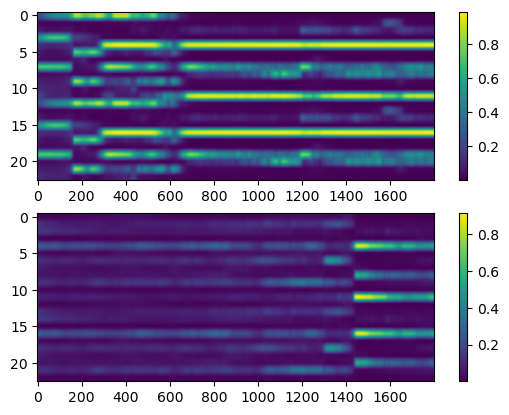

In [6]:
# --- TEST
items, label = train_dataset[0]
print(items.size())
print(label)

plt.subplot(211); plt.imshow(items[0,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();
plt.subplot(212); plt.imshow(items[1,0,:,:].cpu().numpy(), aspect='auto'); plt.colorbar();


### Create DataLoader

In [7]:
def triplet_mining_collate(batch):
    """
    Custom collate function for triplet mining
    :param batch: elements of the mini-batch (pcp features and labels)
    :return: collated elements
    """
    items = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    return torch.cat(items, 0), labels

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.num_of_labels, shuffle=True, collate_fn=triplet_mining_collate, num_workers=9, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.num_of_labels, shuffle=False, collate_fn=triplet_mining_collate, num_workers=9, drop_last=True)

In [9]:
# --- TEST
items, labels = next(iter(train_dataloader))
print(items.size())
print(labels)

torch.Size([64, 1, 23, 1800])
['W_6403', 'W_5930', 'W_13127', 'W_59952', 'W_54466', 'W_4767', 'W_123840', 'W_124809', 'W_1282', 'W_27913', 'W_4687', 'W_63101', 'W_4689', 'W_9571', 'W_4762', 'W_2928']


## Model

In [10]:
with open('config_cover.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)

class CoverModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(CoverModel, self).__init__()
        self.block_l = []
        for config_block in config.model.block_l:
            sequential_l = []
            for config_sequential in config_block.sequential_l:
                component_l = []
                for config_component in config_sequential.component_l:
                    module, current_input_dim = model_factory.f_parse_component(config_component[0], config_component[1], current_input_dim) 
                    component_l.append( module )
                sequential_l.append( nn.Sequential (*component_l) )
            self.block_l.append( nn.ModuleList(sequential_l) )
            self.model = nn.ModuleList(self.block_l)

    def forward(self, X, do_verbose=False):
        for idx_block, block in enumerate(self.model):
            for idx_sequential, sequential in enumerate(block):
                if do_verbose:
                    print(f'{idx_block}/{idx_sequential}---------------------------------')
                    print(sequential)
                    print(f'> in: {X.size()}')
                X = sequential( X )
                if do_verbose:
                    print(f'> out: {X.size()}')
        return X

m, C, H, T = 32, 1, 23, 1800
model = CoverModel(config, [m, C, H, T])
model = model.to(param_model.device)

In [11]:
# --- TEST
#print(model)

#X = torch.randn(m, C, H, T).to(param_model.device)
#print(model(X, True).size())

torchsummary.summary(model, (C, H, T))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 12, 1621]         553,216
             PReLU-2        [-1, 256, 12, 1621]               1
         MaxPool2d-3         [-1, 256, 1, 1621]               0
            Conv2d-4         [-1, 256, 1, 1617]         327,936
             PReLU-5         [-1, 256, 1, 1617]               1
            Conv2d-6         [-1, 256, 1, 1613]         327,936
             PReLU-7         [-1, 256, 1, 1613]               1
            Conv2d-8         [-1, 256, 1, 1609]         327,936
             PReLU-9         [-1, 256, 1, 1609]               1
           Conv2d-10         [-1, 256, 1, 1605]         327,936
            PReLU-11         [-1, 256, 1, 1605]               1
nnAutoPoolWeightSplit-12            [-1, 128, 1, 1]               0
        nnSqueeze-13                  [-1, 128]               0
           Linear-14               

### Define losses

In [12]:
def pairwise_distance_matrix(x, y=None, eps=1e-12):
    """
    Calculating squared euclidean distances between the elements of two tensors
    :param x: first tensor
    :param y: second tensor (optional)
    :param eps: epsilon value for avoiding div by zero
    :return: pairwise distance matrix
    """
    x_norm = x.pow(2).sum(dim=1).view(-1, 1)
    if y is not None:
        y_norm = y.pow(2).sum(dim=1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2 * torch.mm(x, y.t().contiguous())
    return torch.clamp(dist, eps, np.inf)

In [13]:
def f_renumber(labels):
    """
    renumber the labels (which correspond to work-id) starting from 0 and get 4 of them each time
    """
    aux = {}
    i_labels = []
    for l in labels:
        if l not in aux:
            aux[l] = len(aux)
        i_labels += [aux[l]]*4
    return i_labels

#f_renumber([300, 200, 500, 300])

In [14]:
def triplet_loss_mining(embedding_m, labels, param_model):
    """
    Online mining function for selecting the triplets
    """

    batch_size = embedding_m.size(0)

    # creating positive and negative masks for online mining
    i_labels = f_renumber(labels)
    i_labels = torch.Tensor(i_labels).view(-1, 1).to(param_model.device)
    # --- get a ones matrix with zero on main diagonal (to avoid selecting the anchor itself for positive or negative)
    mask_diag = (1 - torch.eye(batch_size)).long().to(param_model.device)
    # --- the mask with 1 if same work-id 0 otherwise
    sameworkid_mask = (pairwise_distance_matrix(i_labels) < 0.5).long()
    # --- same work-id but not the anchor
    mask_pos = mask_diag * sameworkid_mask
    # --- different work-id and not the anchor
    mask_neg = mask_diag * (1 - mask_pos)

    # getting the pairwise distance matrix
    dist_all = pairwise_distance_matrix(embedding_m)  
    # normalizing the distances by the embedding size
    if param_model.norm_dist == 1:  dist_all /= param_model.emb_size

    if param_model.mining_strategy == 0:    dist_pos, dist_neg = triplet_mining_random(dist_all, mask_pos, mask_neg)
    elif param_model.mining_strategy == 1:  dist_pos, dist_neg = triplet_mining_semihard(dist_all, mask_pos, mask_neg, param_model.margin)
    else:                               dist_pos, dist_neg = triplet_mining_hard(dist_all, mask_pos, mask_neg, param_model.device)
    
    loss = F.relu(dist_pos + (param_model.margin - dist_neg))  # calculating triplet loss
    
    nb1 = torch.sum(dist_pos+param_model.margin < dist_neg).item()
    nb2 = torch.sum(loss > 0).item()

    #print(f'ok:{nb1}/used:{nb2}/total:{batch_size} \t loss:{loss.mean().item()}' )
    
    return loss.mean(), nb1#loss.sum()/nb2, nb1


def triplet_mining_random(dist_all, mask_pos, mask_neg):
    """
    Performs online random triplet mining
    """
    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_neg) as the negative
    _, sel_neg = torch.max(mask_neg.float() + torch.rand_like(dist_all), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_semihard(dist_all, mask_pos, mask_neg, margin):
    """
    Performs online semi-hard triplet mining (a random positive, a semi-hard negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (should be from a different work-id)
    # 2) should be P < N < P+margin

    # selecting the positive elements of triplets
    # we consider each row as an anchor and takes the maximum of the masked row (mask_pos) as the positive
    _, sel_pos = torch.max(mask_pos.float() + torch.rand_like(dist_all), dim=1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))
    
    # selecting the negative elements of triplets
    _, sel_neg = torch.max( 
                            (mask_neg + mask_neg * (dist_all < (dists_pos.expand_as(dist_all)).long()+margin)).float() 
                           + torch.rand_like(dist_all), 
                           dim=1)

    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg


def triplet_mining_hard(dist_all, mask_pos, mask_neg, device):
    """
    Performs online hard triplet mining (both positive and negative)
    """

    # --- the code below seems wrong
    # --- need criteria
    # 1) should be negative (from a different work-id)
    # 2) should be N < P

    # selecting the positive elements of triplets
    # --- for each anchor (row) we take the positive with the largest distance
    _, sel_pos = torch.max(dist_all * mask_pos.float(), 1)
    dists_pos = torch.gather(input=dist_all, dim=1, index=sel_pos.view(-1, 1))

    # modifying the negative mask for hard mining (because we will use the min)
    # --- if mask_neg==0 then inf   
    # --- if mask_neg==1 then 1
    true_value = torch.tensor(float('inf'), device=device)
    false_value = torch.tensor(1., device=device)
    mask_neg = torch.where(mask_neg == 0, true_value, false_value)
    # selecting the negative elements of triplets
    # --- for each anchor (row) we take the negative with the smallest distance
    _, sel_neg = torch.min(dist_all + mask_neg.float(), dim=1)
    dists_neg = torch.gather(input=dist_all, dim=1, index=sel_neg.view(-1, 1))

    return dists_pos, dists_neg

## Training using TorchLightning

### W&B configuration

In [15]:
train_config_d = {}
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
expe_name = formatted_datetime
wandb.finish()
wandb_logger = WandbLogger(project = param_wandb.project_name, name = expe_name, save_dir = param_wandb.save_dir )
wandb_logger.experiment.config.update(train_config_d)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geoffroy-peeters (adasp). Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./_cover_wandb/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path ./_cover_wandb/wandb/ wasn't writable, using system temp directory


### TorchLightning

In [16]:
class CoverLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = self.model(items.to(param_model.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_model)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_oktriplet", oktriplet, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        items, labels = batch
        embedding_m = self.model(items.to(param_model.device))
        loss, oktriplet = triplet_loss_mining(embedding_m, labels, param_model)
        self.log("valid_loss", loss, prog_bar=True)
        self.log("valid_oktriplet", oktriplet, prog_bar=True)
         
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=param_model.lr, momentum=param_model.momentum)
        return optimizer

### Training

In [17]:
my_lighting = CoverLigthing(model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=50, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you s

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 152/152 [00:29<00:00,  5.12it/s, v_num=pl18, train_loss=1.350, train_oktriplet=0.000, valid_loss=1.460, valid_oktriplet=0.143]

Metric valid_loss improved. New best score: 1.457


Epoch 1: 100%|██████████| 152/152 [00:28<00:00,  5.27it/s, v_num=pl18, train_loss=1.300, train_oktriplet=0.000, valid_loss=1.280, valid_oktriplet=0.571]

Metric valid_loss improved by 0.176 >= min_delta = 0.0. New best score: 1.281


Epoch 2: 100%|██████████| 152/152 [00:29<00:00,  5.20it/s, v_num=pl18, train_loss=1.270, train_oktriplet=0.000, valid_loss=1.140, valid_oktriplet=1.310]

Metric valid_loss improved by 0.139 >= min_delta = 0.0. New best score: 1.142


Epoch 5: 100%|██████████| 152/152 [00:28<00:00,  5.27it/s, v_num=pl18, train_loss=1.220, train_oktriplet=0.000, valid_loss=1.100, valid_oktriplet=1.510]

Metric valid_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.104


Epoch 6: 100%|██████████| 152/152 [00:28<00:00,  5.26it/s, v_num=pl18, train_loss=1.200, train_oktriplet=0.000, valid_loss=1.090, valid_oktriplet=1.170]

Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.095


Epoch 9: 100%|██████████| 152/152 [00:28<00:00,  5.26it/s, v_num=pl18, train_loss=1.080, train_oktriplet=0.000, valid_loss=1.080, valid_oktriplet=2.090]

Metric valid_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.080


Epoch 10: 100%|██████████| 152/152 [00:29<00:00,  5.18it/s, v_num=pl18, train_loss=1.060, train_oktriplet=2.000, valid_loss=1.070, valid_oktriplet=2.110]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.069


Epoch 11: 100%|██████████| 152/152 [00:30<00:00,  4.99it/s, v_num=pl18, train_loss=1.080, train_oktriplet=2.000, valid_loss=1.030, valid_oktriplet=1.260]

Metric valid_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.029


Epoch 16: 100%|██████████| 152/152 [00:29<00:00,  5.23it/s, v_num=pl18, train_loss=1.040, train_oktriplet=3.000, valid_loss=1.030, valid_oktriplet=1.630]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.027


Epoch 17: 100%|██████████| 152/152 [00:28<00:00,  5.25it/s, v_num=pl18, train_loss=1.120, train_oktriplet=0.000, valid_loss=0.977, valid_oktriplet=1.170]

Metric valid_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.977


Epoch 47: 100%|██████████| 152/152 [00:29<00:00,  5.20it/s, v_num=pl18, train_loss=1.140, train_oktriplet=2.000, valid_loss=0.969, valid_oktriplet=3.170]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.969


Epoch 54: 100%|██████████| 152/152 [00:30<00:00,  5.04it/s, v_num=pl18, train_loss=1.000, train_oktriplet=0.000, valid_loss=0.951, valid_oktriplet=1.540]

Metric valid_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.951


Epoch 79: 100%|██████████| 152/152 [00:42<00:00,  3.57it/s, v_num=pl18, train_loss=0.967, train_oktriplet=1.000, valid_loss=0.947, valid_oktriplet=3.400]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.947


Epoch 81: 100%|██████████| 152/152 [01:07<00:00,  2.26it/s, v_num=pl18, train_loss=0.872, train_oktriplet=2.000, valid_loss=0.938, valid_oktriplet=1.860]

Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.938


Epoch 90: 100%|██████████| 152/152 [00:29<00:00,  5.16it/s, v_num=pl18, train_loss=0.992, train_oktriplet=5.000, valid_loss=0.927, valid_oktriplet=4.000]

Metric valid_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.927


Epoch 104:  77%|███████▋  | 117/152 [00:22<00:06,  5.23it/s, v_num=pl18, train_loss=0.975, train_oktriplet=1.000, valid_loss=0.960, valid_oktriplet=3.800]

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluation

In [22]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = CoverLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/_cover_lighning/best_model_cover.ckpt
<class '__main__.CoverModel'>
<class '__main__.CoverLigthing'>
<class '__main__.CoverModel'>


In [23]:
model.to(param_model.device)
with torch.no_grad():
    model.eval()
    embed_all_m = torch.tensor([], device=param_model.device)
    coverid_l = []
    for performanceid in valid_dataset.data_d.keys():
        items, coverid = valid_dataset.getitem_by_performanceid(performanceid)
        embedding_m = model(items.unsqueeze(0).to(param_model.device))
        embed_all_m = torch.cat((embed_all_m, embedding_m), dim=0) 
        coverid_l.append(coverid)
        
dist_all_m = pairwise_distance_matrix(embed_all_m)
if param_model.norm_dist == 1:  dist_all_m /= param_model.emb_size


#### Compute Ranking Metrics

In [24]:
def F_mean_rank(relevance):
    return relevance.nonzero()[0][0]+1

def F_mean_reciprocal_rank(relevance):
    return 1./ F_mean_rank(relevance)

def F_precision_at_k(relevance, k):
    return np.mean(relevance[:k] != 0)

def F_average_precision(relevance):
    out = [F_precision_at_k(relevance, k + 1) for k in range(relevance.size) if relevance[k]]
    return np.mean(out)

dist_all_np = dist_all_m.cpu().numpy()
nb_target = dist_all_np.shape[0]
dist_all_np += 1e6*np.eye(nb_target) # --- to prevent detecting the target itself
mean_rank_l, mean_reciprocal_rank_l, precision_at_1_l, precision_at_5_l, precision_at_10_l, average_precision_l = [], [], [], [], [], []

score_d = {}
for key in ['mean_rank', 'mean_reciprocal_rank', 'precision_at_1','precision_at_5', 'precision_at_10', 'average_precision']:
    score_d[key] = [] 

for idx_target in range(nb_target):
    relevance = np.asarray([1 if coverid_l[pos]==coverid_l[idx_target] else 0 for pos in np.argsort(dist_all_np[idx_target,:])])    
    score_d['mean_rank'].append( F_mean_rank(relevance) )
    score_d['mean_reciprocal_rank'].append( F_mean_reciprocal_rank(relevance) )
    score_d['precision_at_1'].append( F_precision_at_k(relevance, 1) )
    score_d['precision_at_5'].append( F_precision_at_k(relevance, 5) )
    score_d['precision_at_10'].append( F_precision_at_k(relevance, 10) )
    score_d['average_precision'].append( F_precision_at_k(relevance, 10) )
    
for key in score_d.keys():
    print(f"{key}: {np.mean(np.asarray(score_d[key]))}")

mean_rank: 13.15
mean_reciprocal_rank: 0.3742995389874988
precision_at_1: 0.215
precision_at_5: 0.145
precision_at_10: 0.0975
average_precision: 0.0975


Before training

- mean_rank: 32.695
- mean_reciprocal_rank: 0.3677792953327571
- precision_at_1: 0.29
- precision_at_5: 0.10400000000000001
- precision_at_10: 0.065
- average_precision: 0.065

After training

- mean_rank: 8.955
- mean_reciprocal_rank: 0.6182610269281605
- precision_at_1: 0.52
- precision_at_5: 0.18900000000000003
- precision_at_10: 0.109
- average_precision: 0.109